## Unscented Kalman Filter

This experiment demonstrates the new generalised class for the UKF. We introduce the method needed to apply this generalised class and present two such modules used for experiments of random omission and aggregation respectively. First, we import the necessary packages.


In [1]:
"used for a number of things"
import os
import sys 
import numpy as np
from math import floor

"timer"
import datetime 

"used to save class instances when run finished."
import pickle 

"import stationsim model and ukf"
sys.path.append("../stationsim")
from stationsim_model import Model
from ukf2 import ukf_ss, pickle_main

sys.path.append("ukf_experiments/ukf_modules")
from ukf_fx import fx
from ukf_ex1 import omission_params, ex1_plots
from ukf_ex2 import aggregate_params, ex2_plots




## Experiment 1

We first demonstrate a quick overview usage of this filter for experiment 1 (random omission). We have two dictionaries of parameters, named `model_params` and `ukf_params`, for parameters pertaining to the model and filter respectively.

In [2]:
"""
width - corridor width
height - corridor height

gates_in - how many entrances
gates_out - how many exits
gates_space - how wide are exits 
gates_speed - mean entry speed for agents

speed_min - minimum agents speed to prevent ridiculuous iteration numbers
speed_mean - desired mean of normal distribution of speed of agents
speed_std - as above but standard deviation
speed_steps - how many levels of speed between min and max for each agent

separation - agent radius to determine collisions
wiggle - wiggle distance. how far an agent moves laterally to avoid agent in front.

step_limit - maximum number of model steps.

do_* - bools for saving plotting and animating data. 
"""
model_params = {

'width': 200,
'height': 100,

'gates_in': 3,
'gates_out': 2,
'gates_space': 1,
'gates_speed': 1,

'speed_min': .2,
'speed_mean': 1,
'speed_std': 1,
'speed_steps': 3,

'separation': 5,
'max_wiggle': 1,

'step_limit': 3600,

'do_history': True,
'do_print': True,
}
"""
sample_rate - how often to update kalman filter. higher number gives smoother predictions
do_batch - do batch processing on some pre-recorded truth data.
bring_noise - add noise to measurements?
noise - variance of added noise
a - alpha between 1 and 1e-4 typically determines spread of sigma points.
    however for large dimensions may need to be even higher
b - beta set to 2 for gaussian. determines trust in prior distribution.
k - kappa usually 0 for state estimation and 3-dim(state) for parameters.
    not 100% sure what kappa does. think its a bias parameter.
"""

ukf_params = {      

'sample_rate' : 5,
"do_restrict" : True, 
"bring_noise" : True,
"noise" : 0.5,
"do_batch" : False,

"a": 1,
"b": 2,
"k": 0,

}

With our base parameters defined we now add bespoke parameters specific to the desired experiment. These parameters always include the initial state covariance, process, and sensor noise matrices (`p`, `q`, and `r`) as well as some transition and measurement functions (`fx` and `hx`). We also include an observation key function, indicating at each time point whether an agent has explicit gps style observation, aggregate observations, or no observations at all. Finally, we will always have some file name with which we can save our class instance and instantly recall the data for plots at some later point. 

For each experiment we can then introduce further parameters. For example, in experiment 1 the aim is to choose some subset of our agents randomly and omit their position data. Hence, we have two observed and unobserved groups of agents which we need to separate using some index before the model is run. We do this using the omission function `omission_index` which randomly selects agents to observe throughout the model. Our observation key function `obs_key_func` uses this index simply assigning numbers 2 (gps style observed) to observed agents and 0 (unobserved) otherwise.

We define `fx` to simply be the transition mechanism for our agent based model stationsim and `hx` to simply take the observed subset of our agents.

Finally we have the function `omission_params` which update the `ukf_params` dictionary with all desired values of the above parameters. This dictionary is then ready to be fed into the generalised ukf class.

In [3]:
def omission_index(n,sample_size):
    
    
    """randomly pick agents to omit 
    used in experiment 1 hx function
    
    Parameters 
    ------
    n,p : int
         population `n` and proportion `p` observed. need p in [0,1]
         
    Returns
    ------
    index,index2: array_like:
        `index` of which agents are observed and `index2` their correpsoding
        index for xy coordinates from the desired state vector.
    """
    index = np.sort(np.random.choice(n,sample_size,replace=False))
    index2 = np.repeat(2*index,2)
    index2[1::2] += 1
    return index, index2

def obs_key_func(state, model_params, ukf_params):
    """which agents are observed"""
    
    key = np.zeros(model_params["pop_total"])
    key[ukf_params["index"]] +=2
    return key

def hx1(state, model_params, ukf_params):
    
    
    """Convert each sigma point from noisy gps positions into actual measurements
    
    -   omits pre-definied unobserved agents given by index/index2
    
    Parameters
    ------
    state : array_like
        desired `state` n-dimensional sigmapoint to be converted

    Returns
    ------
    obs_state : array_like
        `obs_state` actual observed state
    """
    obs_state = state[ukf_params["index2"]]
    
    return obs_state   

def omission_params(model_params, ukf_params, prop):
    
    
    """update ukf_params with fx/hx and their parameters for experiment 1
    
    Parameters
    ------
    ukf_params : dict
        
    Returns
    ------
    ukf_params : dict
    """
    n = model_params["pop_total"]
    ukf_params["prop"] = prop
    ukf_params["sample_size"]= floor(n * ukf_params["prop"])

    
    ukf_params["index"], ukf_params["index2"] = omission_index(n, ukf_params["sample_size"])
    ukf_params["p"] = np.eye(2 * n) #inital guess at state covariance
    ukf_params["q"] = np.eye(2 * n)
    ukf_params["r"] = np.eye(2 * ukf_params["sample_size"])#sensor noise
    
    ukf_params["fx"] = fx
    ukf_params["hx"] = hx1
    
    ukf_params["obs_key_func"] = obs_key_func
    ukf_params["pickle_file_name"] = f"ukf_agents_{n}_prop_{prop}.pkl"    
    
    
    return ukf_params

Now apply all the above functions with some specific population size `n` and proportion observed `prop`. We then initialise our ABM and our UKF.

In [4]:
n=5
prop = 0.5
model_params["pop_total"] = n
ukf_params = omission_params(model_params, ukf_params, prop)

Finally, we run the model and UKF together using `u.main()`.

In [5]:
base_model = Model(**model_params)
u = ukf_ss(model_params,ukf_params,base_model)
u.main()

	Iteration: 0/3600
	Iteration: 100/3600
	Iteration: 200/3600
	Iteration: 300/3600
0:00:23.662531


With the model run complete we can produce a number of diagnostic plots save in the specficied directory given below.

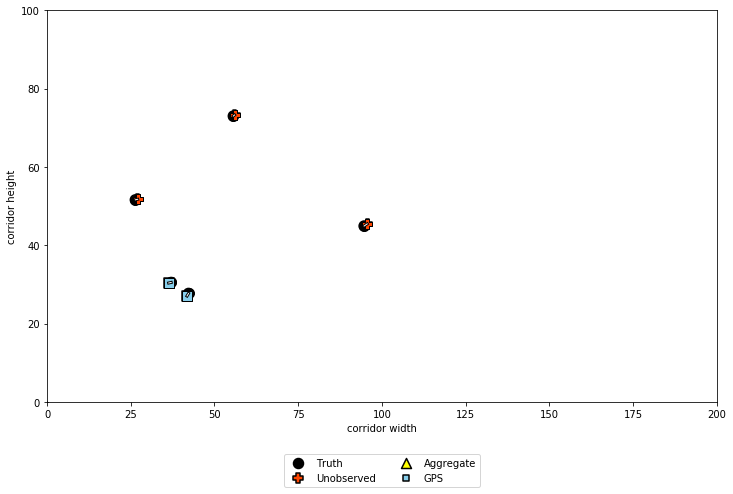

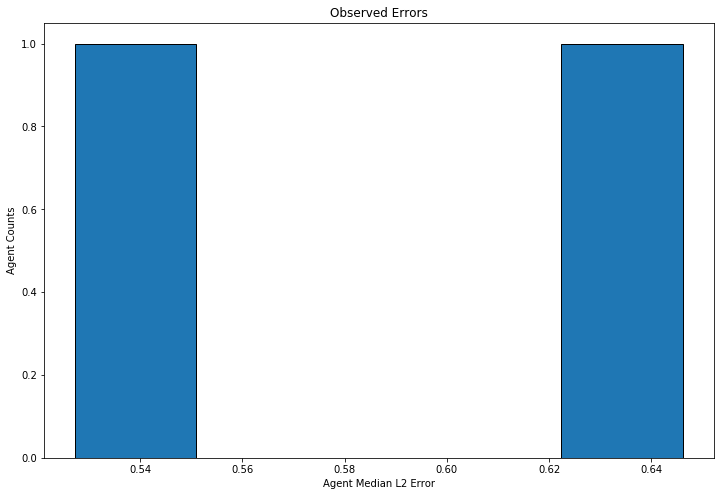

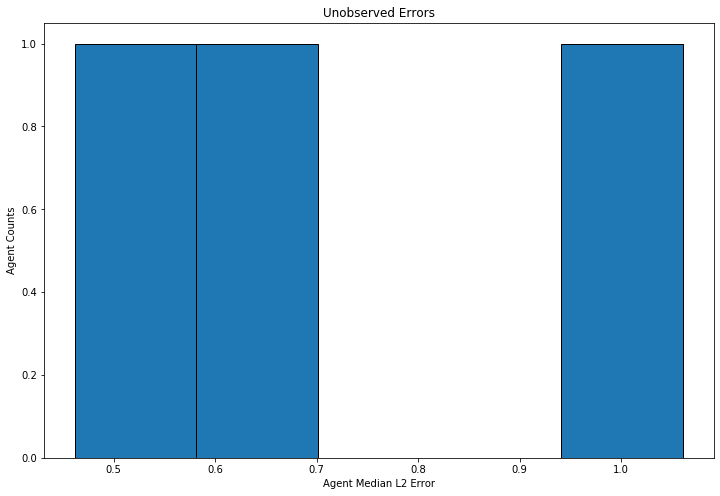

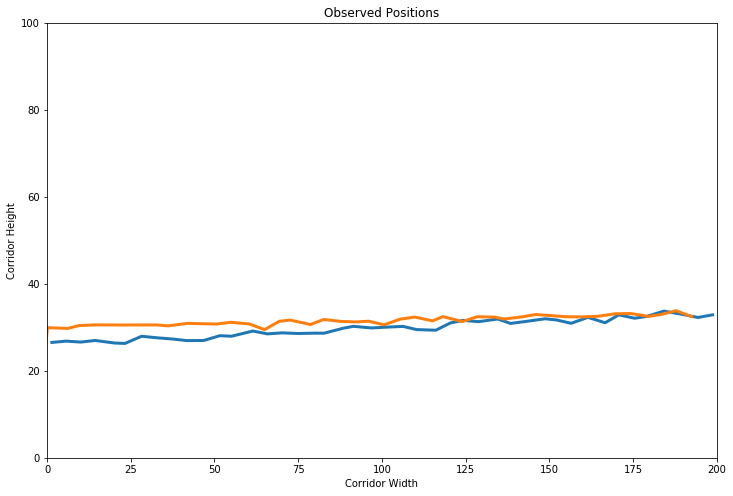

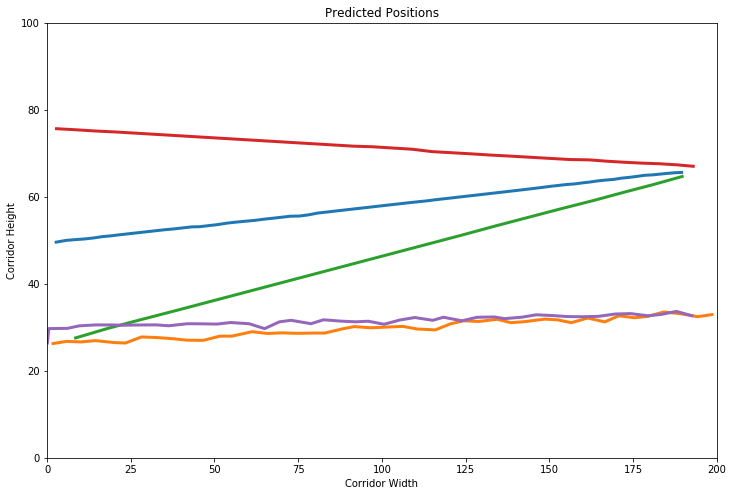

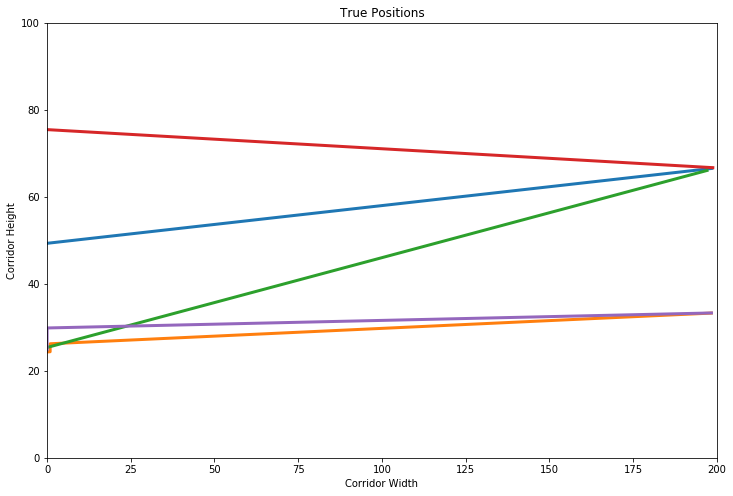

In [6]:
save_dir = "../experiments/ukf_experiments/plots/"

ex1_plots(u, save_dir, "ukf_", True, False)


## Experiment 2
Given configuration functions provide the minimum required parameters to the `ukf_params` dictionary we can in theory apply the fx and hx functions of any desired experiment. We store these in config files such as `ukf_ex1.py` for the above experiment. For example if we wished to instead apply experiment 2, in which we aggregate our data, we load all the requirements from `ukf_ex2.aggregate_params` given a certain population and aggregate square size and again run the `ukf_ss` class in a similar fashion.

Note we can also reset our model/ukf parameter dictionaries to their defaults defined above by importing them from `default_ukf_configs`.

In [7]:
"import default parameters"
from default_ukf_configs import model_params,ukf_params

"set experiment 2 parameters"
n=5
bin_size = 50
"update default parameter dictionaries given n and bin_size"
model_params, ukf_params = aggregate_params(n, bin_size, model_params, ukf_params)

In [8]:
base_model = Model(**model_params)
u2 = ukf_ss(model_params,ukf_params,base_model)
u2.main()

	Iteration: 0/3600
	Iteration: 100/3600
	Iteration: 200/3600
	Iteration: 300/3600
	Iteration: 400/3600
	Iteration: 500/3600
0:00:36.622256


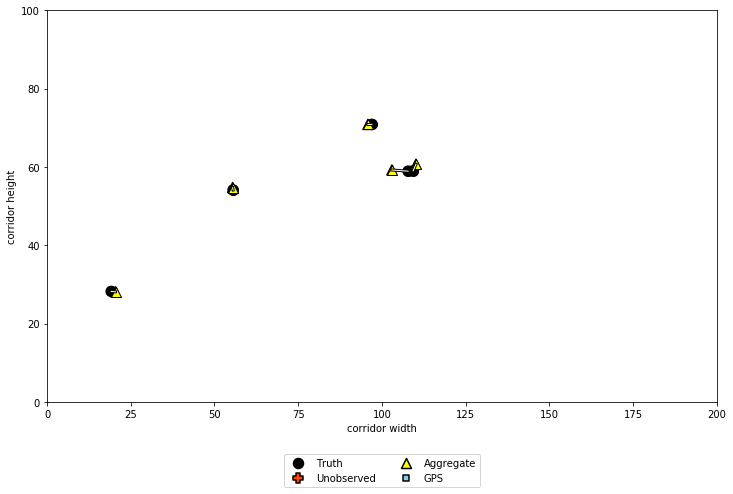

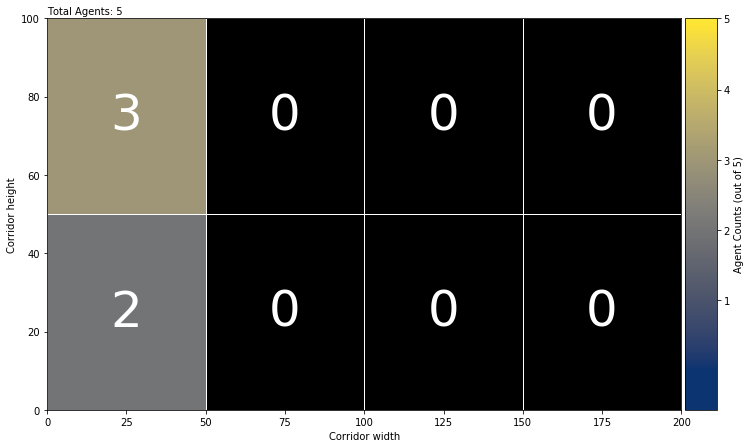

'cant show plots so displaying the saved pngs'

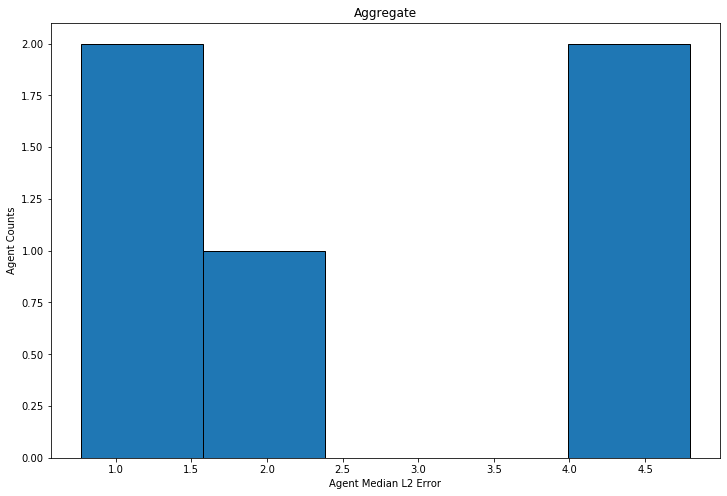

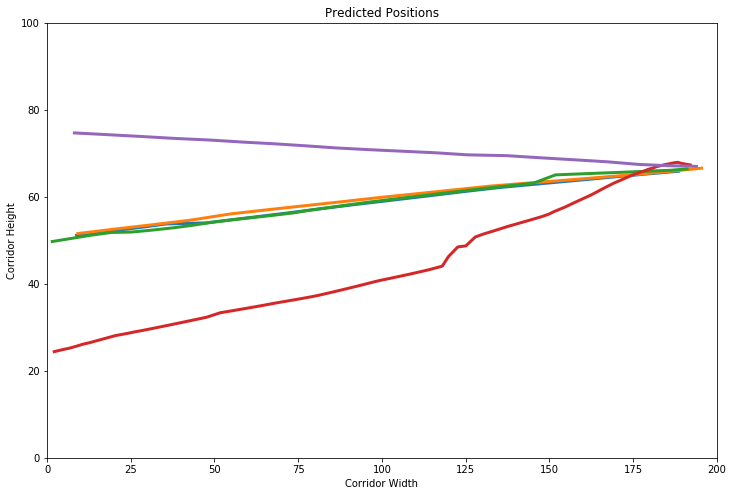

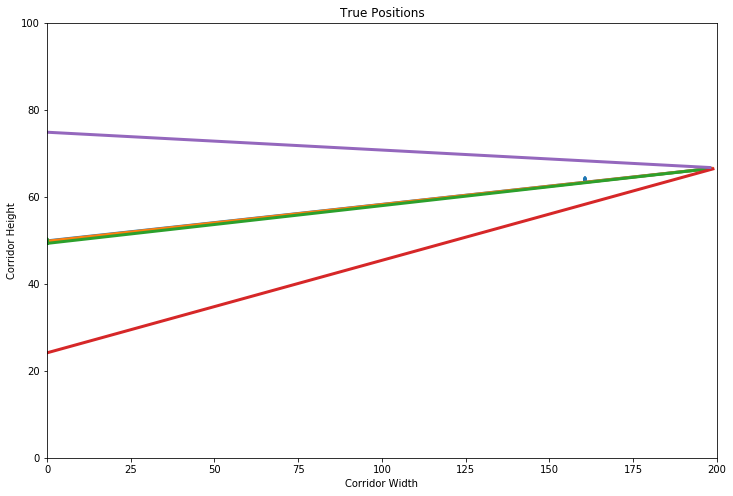

In [9]:
save_dir = "../experiments/ukf_experiments/plots/"

ex2_plots(u2, save_dir, "agg_ukf_", True, False)
"cant show plots so displaying the saved pngs"


## Pickling

To speed things up we can also use pickling to save and easily recall completed ABM runs. To save a run:

In [10]:
n = model_params["pop_total"]
bin_size = ukf_params["bin_size"]
f_name =  f"agg_ukf_agents_{n}_bin_{bin_size}.pkl"
save_dir = "ukf_experiments/test_pickles/"

pickle_main(f_name, save_dir, True, u2)

Pickling file to agg_ukf_agents_5_bin_50.pkl


Recalling a completed run and repeating the same plots

Loading pickle agg_ukf_agents_5_bin_50.pkl


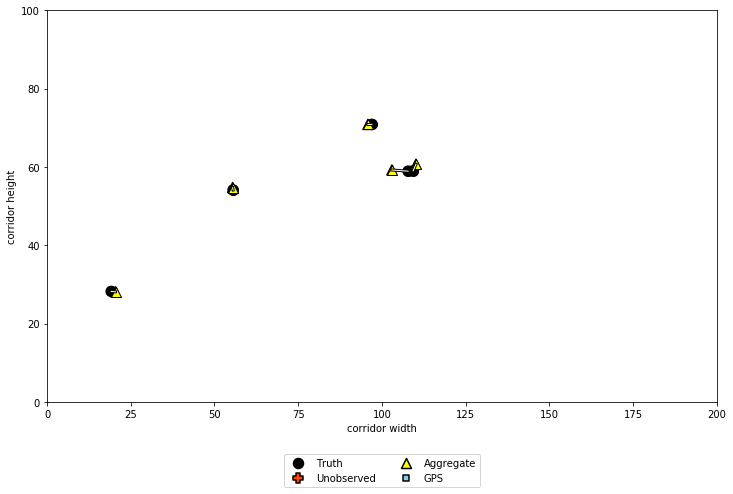

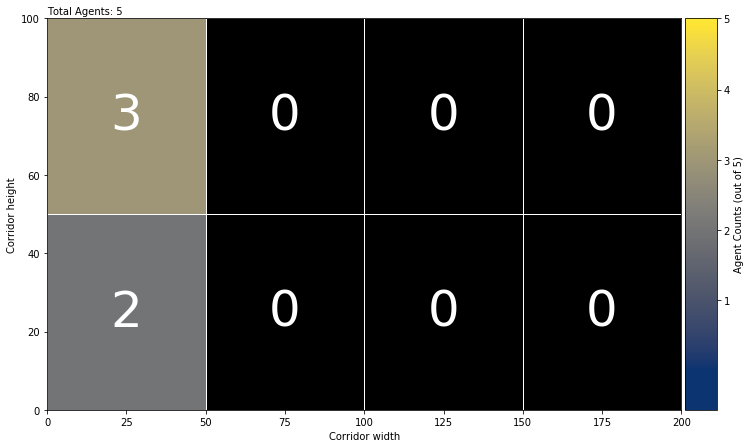

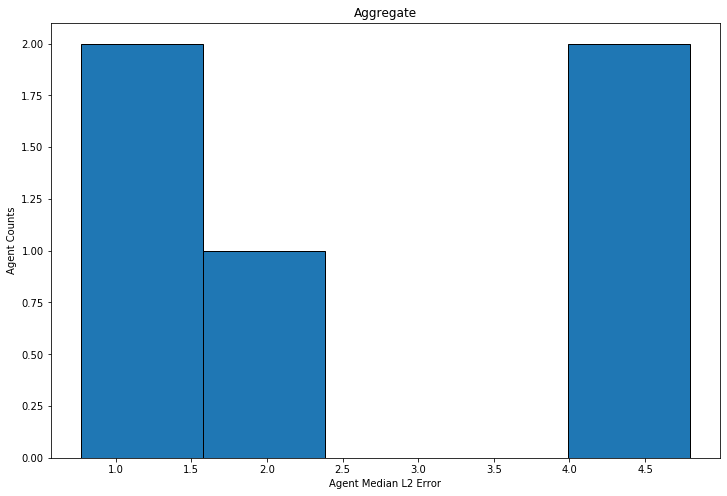

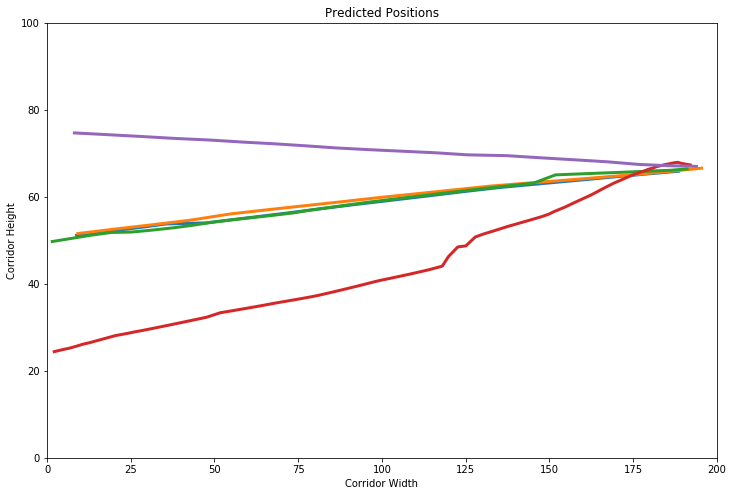

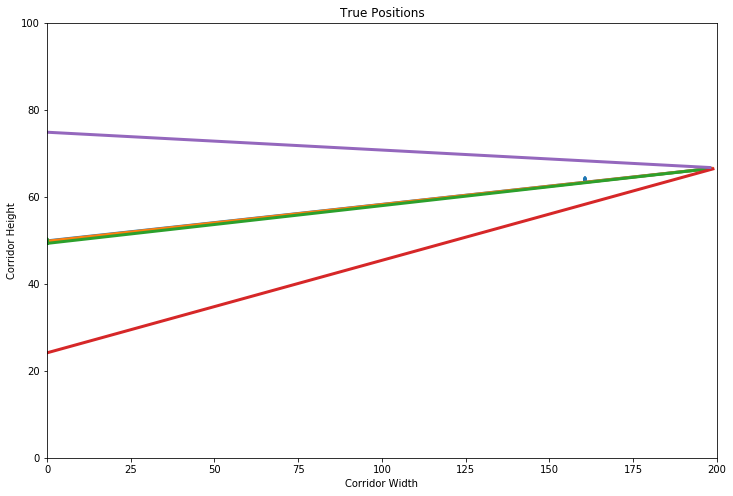

In [12]:
u2 = pickle_main(f_name, "ukf_experiments/test_pickles/", True, instance = None)
save_dir = "ukf_experiments/plots/"
ex2_plots(u2, save_dir, "agg_ukf_", True, False)